# IBCM - LSTM for Sequence Classification

This study attempts to use the constraints generated from iBCM as features to pass into an LSTM network for more efficient sequence classification

In [1]:
#IMPORT LIBRARIES

#Import libraries 
import pandas as pd
import numpy as np
from numpy import array
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score
from iBCM import ConstraintMining, Constraint
from keras.utils import to_categorical
from keras.layers import LSTM, Dense,Dropout, Embedding
from keras.models import Sequential
import time

Using TensorFlow backend.


In [2]:
# DEFINE ALL THE FUNCTIONS

#--------------------------------------------iBCM functions----------------------------------------------
def load_dataset(trace_file, label_file):

    traces = []
    label_list = []
    labels = set()
    constraints_per_label = {}
    for trace, label in zip(trace_file, label_file):
        traces.append(trace)
        label_list.append(label.replace('\n',''))
        labels.add(label.replace('\n',''))
    
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    df = pd.DataFrame({'Traces':traces,'Label':label_list})

    test_len = 1    
    train_len = 0

    while test_len > train_len:
        train, test = train_test_split(df, test_size = 0.1,stratify=df.Label)
        train_len = max([len(x) for x in train.Traces])
        test_len = max([len(x) for x in test.Traces])
        
    train_traces = list(train.Traces)
    train_labels = list(train.Label)
    train_labels_set = set(train_labels)

    test_traces = list(test.Traces)
    test_labels = list(test.Label)
    test_labels_set = set(test_labels)    
    
    def constraints_gen(traces, label_list, labels):
        constraints_per_label = {}
        traces_per_label = {}
        for la, current_label in enumerate(labels):
            print('\nCurrent label: ', current_label)
            final_traces = []
            activity_count = {}
            for label, trace in zip(label_list, traces):
                if label == current_label:
                    trace = trace.replace('\n', '')
                    trace = trace.replace(' -1 -2', '')
    #                print(trace)
                    acts = trace.split(' -1 ')
                    for act in acts:
                        if act not in activity_count.keys():
                            activity_count[act] = 0
                        activity_count[act] += 1
                    final_traces.append(acts)
            traces_per_label[label] = final_traces
            		
            non_redundant_activities = set()
    #        print(activity_count)
            for act, count in activity_count.items():
                if count >= len(final_traces) * min_sup:
                    non_redundant_activities.add(act)
            print('#non-redundant activities: ',len(non_redundant_activities))
            non_redundant_activities = sorted(non_redundant_activities)
    
            constraints_for_label = mine_constraints(final_traces, non_redundant_activities, current_label, no_win)
    #        if current_label == '6':
    #            for c in constraints_for_label:
    #                print(c)        
            constraints_per_label[current_label] = constraints_for_label
        return(constraints_per_label)
            
    constraints_per_label_train = constraints_gen(train_traces, train_labels, train_labels_set)
    constraints_per_label_test  = constraints_gen(test_traces, test_labels, test_labels_set)
    return constraints_per_label_train, constraints_per_label_test


def mine_constraints(traces, non_redundant_activities, label, no_win):
	
    too_short = 0
    constraint_count = {}
    actual_traces = 0
    for t, trace in enumerate(traces):
        if len(trace) >= no_win: 
            actual_traces += 1
            miner = ConstraintMining(trace, label, non_redundant_activities, no_win)
            constraints = miner.FindConstraints()
#            print('Constraints for trace ', t, ' ', constraints)
            for constraint in constraints:
                if constraint not in constraint_count.keys():
                    constraint_count[constraint] = 0
                constraint_count[constraint] += 1
        else:
            too_short += 1
    print('Too short: ', too_short)
    print('#constraints prior removal: ', len(constraint_count))


    to_remove = set()
    for constraint, count in constraint_count.items():
        if count < (actual_traces * min_sup):
            to_remove.add(constraint)
    for tr in to_remove:
        del constraint_count[tr]
#    print('#constraints post removal: ', len(constraint_count))
#    if label == '6':
#        for constraint in constraint_count:
#            print(constraint)
    return constraint_count.keys()


def reduce_feature_space(constraints):
    print('Begin size: ', len(constraints))

    toRemove = set()
    
    lookAt = set()
    lookOut = set()
    for c in constraints:
        if 'succession' in c.name:
            lookAt.add(c)
        if 'response' in c.name or 'precedence' in c.name or 'succession' in c.name or 'co_existence' in c.name:
            lookOut.add(c)

    for c in lookAt:
        for c2 in lookOut:
            if c.w==c2.w and c.a==c2.a and c.b==c2.b:
                if c.name == 'succession' and (c2.name=='response' or c2.name=='precedence'):
                    toRemove.add(c2)
                if c.name == 'alternate_succession' and 'chain' not in c.name and ('response' in c2.name or 'precedence' in c2.name or c2.name=='succession'):
                    toRemove.add(c2)
                if c.name == 'chain_succession' and ('response' in c2.name or 'precedence' in c2.name or c2.name=='succession' or c2.name=='alternate_succession'):
                    toRemove.add(c2)
            if c.w==c2.w and ((c.a==c2.a and c.b==c2.b) or (c.b==c2.a and c.a==c2.b)):   
                 if c.name=='succession' and c2.name=='co_existence':
                     toRemove.add(c2)
    print('Remove size: ', len(toRemove))
    constraints = constraints.difference(toRemove)
    toRemove = set()
		
    lookAt = set()
    for c in constraints:
        if 'response' in c.name or 'precedence' in c.name:
            lookAt.add(c)
		
    for c in lookAt:
        if c.name == 'chain_response':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and c.b==c2.b:
                    if c2.name == 'response' or c2.name == 'alternate_response':
                        toRemove.add(c2)
        if c.name == 'chain_precedence':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and c.b==c2.b:
                    if c2.name == 'precedence' or c2.name == 'alternate_precedence':
                        toRemove.add(c2)
        if c.name == 'alternate_response':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and c.b==c2.b:
                    if c2.name == 'response':
                        toRemove.add(c2)
        if c.name == 'alternate_precedence':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and c.b==c2.b:
                    if c2.name == 'precedence':
                        toRemove.add(c2)                        
    print('Remove size: ', len(toRemove))
    lookAt = set()
    for c in constraints:
        if 'exactly' in c.name or 'existence' in c.name:
            lookAt.add(c)
		
    for c in lookAt:
        if c.name == 'existence3':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and (c2.name=='existence2' or c2.name=='existence'):
                    toRemove.add(c2)
        if c.name == 'existence2':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and c2.name=='existence':
                    toRemove.add(c2)
        if c.name == 'exactly2':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and (c2.name=='existence' or c2.name=='exactly' or c2.name=='existence2'):
                    toRemove.add(c2)                    
        if c.name == 'exactly2':
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and (c2.name=='existence' or c2.name=='exactly' or c2.name=='existence2'):
                    toRemove.add(c2)   
        if ('existence' in c.name or 'exactly' in c.name) and 'co_existence' not in c.name:
            for c2 in lookAt:
                if c.w==c2.w and c.a==c2.a and ('existence' in c2.name or 'exactly' in c2.name) and 'co_existence' not in c2.name:
                    for c3 in constraints:
                        if c3.name=='co_existence' and c2.w==c3.w and ((c.a==c3.a and c2.b==c3.b) or (c.b==c3.a and c2.a==c3.b)):
                            toRemove.add(c3)
    print('Remove size: ', len(toRemove))
    constraints = constraints.difference(toRemove)
    print('End size: ', len(constraints))
    return constraints


def reduce_constraints(constraints_per_label):
    all_constraints = set()
    for label, constraints in constraints_per_label.items():
        print('Label ', label, ' has ', len(constraints), ' constraints')
        all_constraints = all_constraints.union(set(constraints))
    print('\nTotal # constraints: ', len(all_constraints))
    
        
    overlapping = set()
    for constraint in all_constraints:
        overlap = True
        for label, constraints in constraints_per_label.items():
            if constraint not in constraints:
                overlap = False
                break
        if overlap:
            overlapping.add(constraint)
    print('Overlapping constraints: ', len(overlapping))
    all_constraints = all_constraints.difference(overlapping)
    print('Total # constraints w/o overlap: ', len(all_constraints))
    final_constraints = reduce_feature_space(all_constraints)
    print('Final total # constraints: ', len(final_constraints))
    
    return(final_constraints)
#-----------------------------------------------------------end of iBCM Functions--------------------------------------


#Create dataframe from constraints
def create_dataframe (constraints_per_label, final_constraints):     
    import pandas as pd
    
    #------- Filtering constraints per label
    constraints_per_label_filtered = {}    
    for label, constraints in constraints_per_label.items():
            constraint_list = list(constraints)
            filtered_constraints = [x for x in constraint_list if x in final_constraints]
            print('\nAfter removal of non-discriminative constraints, the number of constraints for label ',label,' is ', len(filtered_constraints))
            constraints_per_label_filtered[label] = filtered_constraints
    
    #------------ Creating dataframe with constraints
    
    label_list = []
    const = []
    a_element = []
    b_element = []
    w_element = []
    
    #----------- first creating lists with each element
    for label, constraints in constraints_per_label_filtered.items():
        c_list = list(constraints)
        i = 0
        for i in range(0, len(c_list)):
            label_list.append(label)
            const.append(c_list[i].name)
            a_element.append(c_list[i].a)
            b_element.append(c_list[i].b)
            w_element.append(c_list[i].w) 
    
    constraint_dataframe = pd.DataFrame({'Label':label_list[:],'Item_A':a_element[:],'Item_B':b_element[:],'Constraint':const[:],'Window':w_element[:]})
    
    #--- data type conversions and sorting
    constraint_dataframe['Item_A'] = constraint_dataframe['Item_A'].apply(int)
    constraint_dataframe['Item_B'] = constraint_dataframe['Item_B'].apply(int)
    constraint_dataframe_sorted = constraint_dataframe.sort_values(by = ['Window','Label','Item_A','Item_B'])
    
    return constraint_dataframe_sorted

#Encoding the constraints
def encode_features(constraint_dataframe):
    #get dummy columns first and then join to original df
    one_hot_encoded_constraints = pd.get_dummies(constraint_dataframe['Constraint'])
    one_hot_decoder = one_hot_encoded_constraints.columns
    
    def one_hot_decode(string,one_hot_decoder):
        p = list(one_hot_decoder[np.argwhere(string == np.amax(string)).flatten().tolist()])
        return p
    
    dataframe_encoded = constraint_dataframe.join(one_hot_encoded_constraints)
    
    #aggregate at a label,window, items level so that constraints between items are recorded in one row
    df_enc_agg = dataframe_encoded.groupby(['Label','Window','Item_A','Item_B']).sum().reset_index()
    
    #combine columns into a single vector
    testdf = df_enc_agg.copy()
    col_names = testdf.iloc[:,4:].columns
    col_names = col_names.values
    testdf['constraint_string'] = testdf[col_names].apply(lambda row:''.join(row.values.astype(str)),axis = 1)
    constraint_vector = [np.array(list(x),dtype=int) for x in testdf.constraint_string]
    testdf['Constraint_vector'] = constraint_vector
    encoded_df = testdf[['Label','Item_A','Item_B','Window','Constraint_vector','constraint_string']]
    
    
    # Encoding labels as well
    data = encoded_df['Label']
    data = np.array(data)
    labelenc_2 = LabelEncoder()
    encoded_labels = labelenc_2.fit_transform(data)
    
    
    encoded_constraint_df = encoded_df.copy()
    encoded_constraint_df['Label'] = list(encoded_labels)
        
    return(encoded_constraint_df)


def convert_df_to_3d_array(encoded_constraint_df_train):
    
    #Creating a df with all the items in the dictionary and joining it with the constraints dataframe (left join)
    import itertools
    Label_range = list(set(encoded_constraint_df_train.Label))
    column_list = [Label_range,Window_range,Item_A_range,Item_B_range]
    data = list(itertools.product(*column_list))
    complete_df = pd.DataFrame(data,columns = ['Label','Window','Item_A','Item_B'])
    encoded_train = complete_df.merge(encoded_constraint_df_train,on=['Label','Window','Item_A','Item_B'],how ='left')
    zeros_string = '0'*num_const
    zeros_vector = np.zeros(num_const,dtype=int)
    encoded_train.constraint_string.fillna(zeros_string,inplace=True)
    
    df_4 = encoded_train.astype('object')
    df_4.Constraint_vector[df_4.Constraint_vector.isnull()] = [[zeros_vector]]
    df_str = df_4[['Label','Window','Item_A','Item_B','constraint_string']]
    
    #Creating dictionary of (constraints per window) per label
    def dict_create(df_str,lab):
        win_dict = {}
        for w in Window_range:
            subset = df_str[(df_str.Label == lab) & (df_str.Window == w)]        
            subset = subset[['Item_A','Item_B','constraint_string']]
            a = subset.pivot(index = 'Item_A',columns='Item_B')
            LEnc = LabelEncoder()
            a = LEnc.fit_transform(a.values.flatten())
            win_dict[w] = a
        arr = np.vstack((win_dict[i] for i in sorted(win_dict.keys())))
        return arr
    
    lab_dict = {}
    for i in Label_range:
        lab_dict[i] = dict_create(df_str,i)
        
    keys = []
    values = []
    
    #Flattening
    for key, value in lab_dict.items():
        keys.append(key)
        values.append(value) 
    array_3d = np.array(values)
    return array_3d

In [3]:
support_range = [0.25,0.5,0.75,1]
window_range = [5, 10, 1]

results_dataframe_2 = pd.DataFrame(columns = ['Support', 
                             'Window',
                             'Accuracy',
                             'Loss Score',
                             'Train size',
                             'Dataset time',
                             'Model_time','Macro Precision','Micro Precision','Macro Recall','Micro Recall',
                                              'Macro f1','Micro f1','ConfM','Macro AUC',
                                                         'Micro AUC',
                                                         'Weighted AUC'])

Now that the functions have been defined and data has been reshaped, the model can be built and run

In [5]:
# RUNNING iBCM 
for min_sup in support_range:
    for no_win in window_range:
    # SELECT FILE HERE
        name = 'context'

        traces = open(name+'.dat', 'r')
        labels = open(name+'.lab', 'r')

        start = time.time()
        constraints = set()

        constraints_per_label_train, constraints_per_label_test = load_dataset(traces, labels)

        #        print('\n\n**********************\nFinal stats: ')
        final_constraints_train = reduce_constraints(constraints_per_label_train)      
        final_constraints_test = reduce_constraints(constraints_per_label_test)

        # ENCODING FEATURES
        constraint_dataframe_train = create_dataframe(constraints_per_label_train, final_constraints_train)
        constraint_dataframe_test = create_dataframe(constraints_per_label_test, final_constraints_test)

        ## Encoding constraints so as to make 3D matrix with items and constraints
        encoded_constraint_df_train = encode_features(constraint_dataframe_train)
        encoded_constraint_df_test = encode_features(constraint_dataframe_test)

        end = time.time()
        #Dataset creation time
        ds_creation_time = round(end-start)

        Item_A_range = list(range(1,max(set(encoded_constraint_df_train.Item_A).union(set(encoded_constraint_df_test.Item_A)))+1))
        Item_B_range = list(range(1,max(set(encoded_constraint_df_train.Item_B).union(set(encoded_constraint_df_test.Item_B)))+1))
        Window_range = list(set(encoded_constraint_df_train.Window).union(set(encoded_constraint_df_test.Window)))
        lab_range = list(set(encoded_constraint_df_train.Label).union(set(encoded_constraint_df_test.Label)))
        num_const = max(len(encoded_constraint_df_test.Constraint_vector[0]),len(encoded_constraint_df_train.Constraint_vector[0]))
        num_lab = len(lab_range)
        num_win = len(Window_range)

        start = time.time()
        x_train = convert_df_to_3d_array(encoded_constraint_df_train)
        x_test  = convert_df_to_3d_array(encoded_constraint_df_test)
        end = time.time()
        #3D array conversion time
        array_time = round(end-start,2)

        #Total dataset creation time
        total_time = ds_creation_time + array_time

        y_train = np.array(list(set(encoded_constraint_df_train.Label)))
        y_test = np.array(list(set(encoded_constraint_df_test.Label)))

        print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

        start = time.time()
        #Hyperparameters
        batch_size = 1
        n_epochs = 50
        cells = 32

        model = Sequential()
        model.add(LSTM(cells, dropout=0.2, input_shape = x_train.shape[1:], recurrent_dropout=0.2,return_sequences = False))
        model.add(Dense(num_lab,activation = 'softmax'))
        model.summary()
        model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "nadam", metrics = ['accuracy'])
        history = model.fit(x_train, y_train,epochs=n_epochs, validation_data=(x_test, y_test))
        end = time.time()
        exec_time = round(end - start,3)
        model_time = exec_time
        evaluation = model.evaluate(x_test, y_test)

        yhat_probs = model.predict(x_test, verbose=0)
        # predict crisp classes for test set
        yhat_classes = model.predict_classes(x_test, verbose=0)

        #Classification evaluation metrics
        accuracy = accuracy_score(y_test, yhat_classes)
        macro_precision = precision_score(y_test, yhat_classes,average='macro')
        micro_precision = precision_score(y_test, yhat_classes,average='micro')
        macro_recall = recall_score(y_test, yhat_classes,average='macro')
        micro_recall = recall_score(y_test, yhat_classes,average='micro')
        macro_f1 = f1_score(y_test, yhat_classes, average='macro')
        micro_f1 = f1_score(y_test, yhat_classes, average='micro')

        #Need to binarize for multiclass AUC
        lb = LabelBinarizer()
        lb.fit(y_test)
        bin_lab_test = lb.transform(y_test)
        bin_lab_pred = lb.transform(yhat_classes)

        macro_auc = roc_auc_score(bin_lab_test, bin_lab_pred, average = 'macro')
        micro_auc = roc_auc_score(bin_lab_test, bin_lab_pred, average = 'micro')
        weighted_auc = roc_auc_score(bin_lab_test, bin_lab_pred, average = 'weighted')

        from matplotlib import pyplot as plt
        cm = confusion_matrix(y_test,yhat_classes)


        results_dataframe_2 = results_dataframe_2.append({'Support':min_sup, 
                                                         'Window':no_win,
                                                         'Accuracy':evaluation[1],
                                                         'Loss Score':evaluation[0],
                                                         'Train size':x_train.size,
                                                         'Dataset time':total_time,
                                                         'Model_time':model_time,
                                                         'Macro Precision':macro_precision,
                                                         'Micro Precision':micro_precision,
                                                         'Macro Recall':macro_recall,
                                                        'Micro Recall':micro_recall,
                                                         'Macro f1':macro_f1,
                                                         'Micro f1':micro_f1,
                                                         'ConfM':cm,
                                                         'Macro AUC':macro_auc,
                                                         'Micro AUC':micro_auc,
                                                         'Weighted AUC':weighted_auc},ignore_index=True)

        results_dataframe_2.to_excel('%s_AUC.xlsx'%name)


Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  14966

Current label:  3
#non-redundant activities:  42
Too short:  0
#constraints prior removal:  17807

Current label:  4
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  12166

Current label:  2
#non-redundant activities:  44
Too short:  0
#constraints prior removal:  12669

Current label:  1
#non-redundant activities:  58
Too short:  0
#constraints prior removal:  19010

Current label:  5
#non-redundant activities:  34
Too short:  0
#constraints prior removal:  9566

Current label:  3
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  8543

Current label:  4
#non-redundant activities:  38
Too short:  0
#constraints prior removal:  5299

Current label:  2
#non-redundant activities:  44
Too short:  0
#constraints prior removal:  6530

Current label:  1
#non-redundant activities:  70
Too short:  0
#constraints prior removal:  11097
Label  5  has 

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
W0821 20:14:06.771094  6036 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 20:14:06.789117  6036 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 20:14:06.792075  6036 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please us

(5, 5, 4900) (5, 5, 4900) (5,) (5,)


W0821 20:14:07.085291  6036 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 20:14:07.101249  6036 deprecation_wrapper.py:119] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\keras\backend\tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.

W0821 20:14:07.196945  6036 deprecation.py:323] From C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                631424    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 631,589
Trainable params: 631,589
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 1s 178ms/step - loss: 1.2787 - acc: 0.6000 - val_loss: 1.1978 - val_acc: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.9131 - acc: 0.8000 - val_loss: 0.8082 - val_acc: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5288 - acc: 1.0000 - val_loss: 0.5129 - val_acc: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2447 - acc: 1.0000 - val_loss: 0

Remove size:  2233
Remove size:  5
Remove size:  52
End size:  2224
Final total # constraints:  2224
Label  5  has  4224  constraints
Label  3  has  3221  constraints
Label  4  has  892  constraints
Label  2  has  1530  constraints
Label  1  has  4874  constraints

Total # constraints:  9574
Overlapping constraints:  395
Total # constraints w/o overlap:  9179
Begin size:  9179
Remove size:  5143
Remove size:  9
Remove size:  49
End size:  3987
Final total # constraints:  3987

After removal of non-discriminative constraints, the number of constraints for label  5  is  1141

After removal of non-discriminative constraints, the number of constraints for label  3  is  1156

After removal of non-discriminative constraints, the number of constraints for label  4  is  215

After removal of non-discriminative constraints, the number of constraints for label  2  is  504

After removal of non-discriminative constraints, the number of constraints for label  1  is  812

After removal of non-discr

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 10, 5184) (5, 10, 5184) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                667776    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 667,941
Trainable params: 667,941
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 1s 160ms/step - loss: 1.4886 - acc: 0.4000 - val_loss: 1.1289 - val_acc: 0.8000
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.9856 - acc: 0.8000 - val_loss: 0.9180 - val_acc: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6409 - acc: 1.0000 - val_loss: 0.7313 - val_acc: 0.8000
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - lo

Overlapping constraints:  1039
Total # constraints w/o overlap:  7044
Begin size:  7044
Remove size:  2794
Remove size:  146
Remove size:  178
End size:  4072
Final total # constraints:  4072
Label  5  has  2510  constraints
Label  3  has  3218  constraints
Label  4  has  2467  constraints
Label  2  has  3913  constraints
Label  1  has  10354  constraints

Total # constraints:  12458
Overlapping constraints:  1050
Total # constraints w/o overlap:  11408
Begin size:  11408
Remove size:  5308
Remove size:  258
Remove size:  288
End size:  5812
Final total # constraints:  5812

After removal of non-discriminative constraints, the number of constraints for label  5  is  829

After removal of non-discriminative constraints, the number of constraints for label  3  is  1180

After removal of non-discriminative constraints, the number of constraints for label  4  is  763

After removal of non-discriminative constraints, the number of constraints for label  2  is  1660

After removal of non-dis

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 1, 7056) (5, 1, 7056) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                907392    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 907,557
Trainable params: 907,557
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 1s 256ms/step - loss: 1.6295 - acc: 0.0000e+00 - val_loss: 1.4509 - val_acc: 0.2000
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 1.3186 - acc: 0.6000 - val_loss: 1.3382 - val_acc: 0.4000
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 1.3429 - acc: 0.4000 - val_loss: 1.2962 - val_acc: 0.4000
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - 

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  15045

Current label:  3
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  14433

Current label:  4
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  11152

Current label:  2
#non-redundant activities:  42
Too short:  0
#constraints prior removal:  11675

Current label:  1
#non-redundant activities:  46
Too short:  0
#constraints prior removal:  15868

Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  7789

Current label:  3
#non-redundant activities:  44
Too short:  0
#constraints prior removal:  8904

Current label:  4
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  4642

Current label:  2
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  4577

Current label:  1
#non-redundant activities:  52
Too short:  0
#constraints prior removal:  7499
Label  5  has  

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 5, 4900) (5, 5, 4900) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                631424    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 631,589
Trainable params: 631,589
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 1s 234ms/step - loss: 1.8147 - acc: 0.2000 - val_loss: 1.3086 - val_acc: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 0.8931 - acc: 0.8000 - val_loss: 1.0375 - val_acc: 0.6000
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6466 - acc: 1.0000 - val_loss: 0.8486 - val_acc: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  21730

Current label:  3
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  20304

Current label:  4
#non-redundant activities:  28
Too short:  0
#constraints prior removal:  10041

Current label:  2
#non-redundant activities:  42
Too short:  0
#constraints prior removal:  12536

Current label:  1
#non-redundant activities:  46
Too short:  0
#constraints prior removal:  17051

Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  7636

Current label:  3
#non-redundant activities:  40
Too short:  0
#constraints prior removal:  8888

Current label:  4
#non-redundant activities:  28
Too short:  0
#constraints prior removal:  2797

Current label:  2
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  3568

Current label:  1
#non-redundant activities:  44
Too short:  0
#constraints prior removal:  4194
Label  5  has  

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 10, 5776) (5, 10, 5776) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                743552    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 743,717
Trainable params: 743,717
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 1s 269ms/step - loss: 1.6605 - acc: 0.0000e+00 - val_loss: 1.3069 - val_acc: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 1.1394 - acc: 0.8000 - val_loss: 1.1802 - val_acc: 0.6000
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 0.9644 - acc: 0.8000 - val_loss: 1.0400 - val_acc: 0.8000
Epoch 4/50
5/5 [==============================] - 0s 9ms/step

Remove size:  1426
Remove size:  40
Remove size:  42
End size:  2373
Final total # constraints:  2373
Label  5  has  2194  constraints
Label  3  has  2616  constraints
Label  4  has  1406  constraints
Label  2  has  3529  constraints
Label  1  has  7271  constraints

Total # constraints:  8681
Overlapping constraints:  754
Total # constraints w/o overlap:  7927
Begin size:  7927
Remove size:  3340
Remove size:  184
Remove size:  196
End size:  4391
Final total # constraints:  4391

After removal of non-discriminative constraints, the number of constraints for label  5  is  666

After removal of non-discriminative constraints, the number of constraints for label  3  is  889

After removal of non-discriminative constraints, the number of constraints for label  4  is  312

After removal of non-discriminative constraints, the number of constraints for label  2  is  1129

After removal of non-discriminative constraints, the number of constraints for label  1  is  1491

After removal of non-

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 1, 5476) (5, 1, 5476) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                705152    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 705,317
Trainable params: 705,317
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 1s 279ms/step - loss: 1.5066 - acc: 0.4000 - val_loss: 0.9856 - val_acc: 0.8000
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.9721 - acc: 0.6000 - val_loss: 0.9888 - val_acc: 0.6000
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.7655 - acc: 1.0000 - val_loss: 0.7821 - val_acc: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss

Remove size:  1251
Remove size:  7
Remove size:  9
End size:  1384
Final total # constraints:  1384

After removal of non-discriminative constraints, the number of constraints for label  5  is  489

After removal of non-discriminative constraints, the number of constraints for label  3  is  310

After removal of non-discriminative constraints, the number of constraints for label  4  is  117

After removal of non-discriminative constraints, the number of constraints for label  2  is  212

After removal of non-discriminative constraints, the number of constraints for label  1  is  360

After removal of non-discriminative constraints, the number of constraints for label  5  is  404

After removal of non-discriminative constraints, the number of constraints for label  3  is  710

After removal of non-discriminative constraints, the number of constraints for label  4  is  161

After removal of non-discriminative constraints, the number of constraints for label  2  is  204

After removal of 

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 5, 4900) (5, 5, 4900) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                631424    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 631,589
Trainable params: 631,589
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 2s 321ms/step - loss: 1.7480 - acc: 0.2000 - val_loss: 1.4234 - val_acc: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.2091 - acc: 0.8000 - val_loss: 1.2050 - val_acc: 0.6000
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.8604 - acc: 0.8000 - val_loss: 1.0523 - val_acc: 0.8000
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 10, 4624) (5, 10, 4624) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                596096    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 165       
Total params: 596,261
Trainable params: 596,261
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 2s 340ms/step - loss: 1.6591 - acc: 0.2000 - val_loss: 1.5134 - val_acc: 0.2000
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 1.3210 - acc: 0.4000 - val_loss: 1.3723 - val_acc: 0.2000
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 1.1205 - acc: 0.6000 - val_loss: 1.2345 - val_acc: 0.4000
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - lo

Remove size:  1062
Remove size:  33
Remove size:  33
End size:  1852
Final total # constraints:  1852
Label  5  has  1564  constraints
Label  3  has  1858  constraints
Label  4  has  871  constraints
Label  2  has  2402  constraints
Label  1  has  3766  constraints

Total # constraints:  4713
Overlapping constraints:  456
Total # constraints w/o overlap:  4257
Begin size:  4257
Remove size:  1651
Remove size:  61
Remove size:  73
End size:  2533
Final total # constraints:  2533

After removal of non-discriminative constraints, the number of constraints for label  5  is  549

After removal of non-discriminative constraints, the number of constraints for label  3  is  667

After removal of non-discriminative constraints, the number of constraints for label  4  is  110

After removal of non-discriminative constraints, the number of constraints for label  2  is  781

After removal of non-discriminative constraints, the number of constraints for label  1  is  1301

After removal of non-disc

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 1, 4624) (5, 1, 4624) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 32)                596096    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 596,261
Trainable params: 596,261
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 2s 307ms/step - loss: 1.4887 - acc: 0.4000 - val_loss: 1.1507 - val_acc: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.9832 - acc: 1.0000 - val_loss: 0.8581 - val_acc: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.7366 - acc: 1.0000 - val_loss: 0.8598 - val_acc: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 5, 4900) (5, 5, 4900) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                631424    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 631,589
Trainable params: 631,589
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 2s 345ms/step - loss: 1.5605 - acc: 0.4000 - val_loss: 1.5762 - val_acc: 0.4000
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 1.4496 - acc: 0.6000 - val_loss: 1.5109 - val_acc: 0.4000
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 1.3557 - acc: 0.8000 - val_loss: 1.4555 - val_acc: 0.4000
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  21592

Current label:  3
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  16221

Current label:  4
#non-redundant activities:  24
Too short:  0
#constraints prior removal:  8290

Current label:  2
#non-redundant activities:  24
Too short:  0
#constraints prior removal:  7538

Current label:  1
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  11413

Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  7619

Current label:  3
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  6368

Current label:  4
#non-redundant activities:  22
Too short:  0
#constraints prior removal:  1649

Current label:  2
#non-redundant activities:  28
Too short:  0
#constraints prior removal:  2606

Current label:  1
#non-redundant activities:  40
Too short:  0
#constraints prior removal:  4044
Label  5  has  62

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 10, 3136) (5, 10, 3136) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 32)                405632    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 165       
Total params: 405,797
Trainable params: 405,797
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 2s 357ms/step - loss: 1.6212 - acc: 0.0000e+00 - val_loss: 1.4911 - val_acc: 0.8000
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 1.5826 - acc: 0.4000 - val_loss: 1.4656 - val_acc: 0.8000
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 1.5615 - acc: 0.6000 - val_loss: 1.4315 - val_acc: 0.8000
Epoch 4/50
5/5 [==============================] - 0s 5ms/step 

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Current label:  5
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  4095

Current label:  3
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  3950

Current label:  4
#non-redundant activities:  22
Too short:  0
#constraints prior removal:  2619

Current label:  2
#non-redundant activities:  24
Too short:  0
#constraints prior removal:  2338

Current label:  1
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  4121

Current label:  5
#non-redundant activities:  32
Too short:  0
#constraints prior removal:  3255

Current label:  3
#non-redundant activities:  36
Too short:  0
#constraints prior removal:  3742

Current label:  4
#non-redundant activities:  26
Too short:  0
#constraints prior removal:  2447

Current label:  2
#non-redundant activities:  30
Too short:  0
#constraints prior removal:  2597

Current label:  1
#non-redundant activities:  34
Too short:  0
#constraints prior removal:  3196
Label  5  has  275  

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\ipykernel_launcher.py:332: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(5, 1, 3136) (5, 1, 3136) (5,) (5,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 32)                405632    
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 165       
Total params: 405,797
Trainable params: 405,797
Non-trainable params: 0
_________________________________________________________________
Train on 5 samples, validate on 5 samples
Epoch 1/50
5/5 [==============================] - 2s 384ms/step - loss: 1.6640 - acc: 0.0000e+00 - val_loss: 1.6715 - val_acc: 0.2000
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 1.1062 - acc: 1.0000 - val_loss: 1.6974 - val_acc: 0.2000
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.7813 - acc: 1.0000 - val_loss: 1.6905 - val_acc: 0.2000
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - 

C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\katri\Anaconda3\envs\DL_TF2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


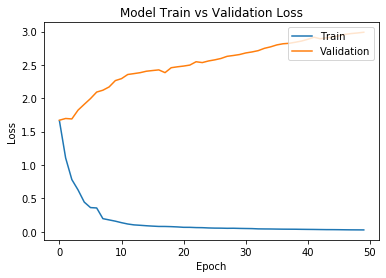

In [6]:
#Plot the training vs validation loss to check for overfitting
%matplotlib inline
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

Note : This plot is only for the last model of the loop. The plot was used in the inital stages of building the model.

(0, 5)

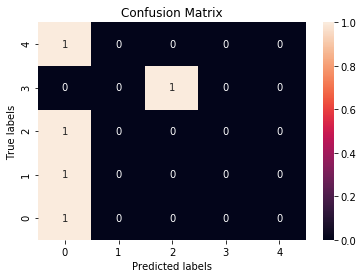

In [7]:
#Create Confusion Matrix
import seaborn as sn
from matplotlib import pyplot as plt
ax = plt.subplot()
cm = confusion_matrix(y_test,yhat_classes)
cm_df = pd.DataFrame(cm)
#sn.set(font_scale=1) #for label size
sn.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.set_ylim(0,5)

This confusion matrix is for the last model in the loop. It may or may not be the best one.